In [2]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### <b> Importing Modules </b>

In [3]:
import pandas as pd
import scipy.spatial.distance as dist
import numpy as np
from sklearn import metrics
import statistics
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances


import warnings
warnings.filterwarnings("ignore")

### Scaling Data using MinMaxScaler

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [5]:
df = pd.read_csv("mid-term-data.csv")

In [6]:
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

In [7]:
df_scaled.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


### <b> Optional to use the PFA reduction technique </b>

In [8]:
#Using this just for PFA calculations
from sklearn.cluster import KMeans

In [9]:
#https://stats.stackexchange.com/questions/108743/methods-in-r-or-python-to-perform-feature-selection-in-unsupervised-learning
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [10]:
pfa = PFA(n_features=10)
pfa.fit(df)
# To get the transformed matrix
x = pfa.features_
# To get the column indices of the features that need to be kept
column_indices = pfa.indices_

In [11]:
column_indices

[0, 1, 2, 3, 4, 5, 7, 8, 9, 12]

In [12]:
df_featured=df_scaled[['f1','f2','f3','f4','f5','f6','f8','f10','f13']]

### Clustering Algorithm

In [13]:
class KMeans_custom(object):
    '''
    This is the constructor of our KMeans_custom object to which we can pass 4 optional attributes.
    1. n_clusters --> signifies number of clusters, default value = 8
    2. max_iter --> maximum number of iterations before you want to stop, default value = 200
    3. dist_metric --> choice of distance metric, default value = euclidean, 
                         possible choices = ['euclidean','manhattan','cosine','chebyshev','canberra']
    4. random_state --> random seed value to pick our centroids, default value = None
    '''
    def __init__(self, n_clusters=8, max_iter=200, dist_metric='euclidean', random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.dist_metric = dist_metric

    #the fit function does calculation of labels for max_iter number of iterations based on input or default
    def fit(self, X):
        
        #fit requires input to be a numpy array so converting to numpy array if DataFrame is passed as input
        if type(X) == pd.core.frame.DataFrame:
            X = X.to_numpy()
            
        #using random_state to pick up initial k-cluster centroids
        if self.random_state:
            np.random.seed(self.random_state)
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.cluster_centers_ = X[initial]
        count = 0
        prev_labels = []
        #running through multiple iterations to find our labels while updating our cluster_centers
        for _ in range(self.max_iter):
            #calculate labels
            self.labels_ = [self._nearest(self.cluster_centers_, x, self.dist_metric) for x in X]
            index_rows = [[i for i, l in enumerate(self.labels_) if l == j]
                        for j in range(self.n_clusters)]
            clusters_data = [X[i] for i in index_rows]
            # update the clusters_centers
            self.cluster_centers_ = [c.sum(axis=0) / len(c) for c in clusters_data]
            count+=1
            #to check if labels actually change in each iteration, break early if convergence met
            if(prev_labels == self.labels_):
                break
            prev_labels = self.labels_
        
        
        #sum of square distances from the closest cluster
        print("No. of iterations to convergence: " +str(count))
        
        #calculating our inertia after fitting the data once convergence is met
        self.inertia_ = sum(((self.cluster_centers_[l] - x)**2).sum()
                        for x, l in zip(X, self.labels_))
        return self
    
    def _nearest(self, clusters, x, dist_metric):
        #returns which cluster_center is a specific point in our dataset closest to
        return np.argmin([self._distance(x, c,dist_metric) for c in clusters])

    def _distance(self, a, b, dist_metric):
        #distance metric to be used for distance calculation
        if dist_metric == 'manhattan':  
            return dist.cityblock(a,b)
        elif dist_metric == 'cosine':  
            return dist.cosine(a,b)
        elif dist_metric == 'chebyshev':  
            return dist.chebyshev(a,b)
        elif dist_metric == 'canberra':  
            return dist.canberra(a,b)
        else:
            return dist.euclidean(a,b)

    def predict(self, X):
        #returning labels calculated in the fit method
        return self.labels_

    def transform(self, X):
        #transform helps us to convert the original df/nparray to a cluster distance space if needed
        return [[self._distance(x, c,dist_metric) for c in self.cluster_centers_] for x in X]

    #shortcut methods to fit-predict or fit-transform
    def fit_predict(self, X):
        return self.fit(X).predict(X)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

### Optimal Number of Clusters

#### The optimal number of clusters is determined using 4 different metrics to make our model more comprehensive
The four metrics are: inertia score, silhouette score, calinski harabaz index & davies bouldin score

In [14]:
def optimal_clusters(data):
    #empty lists to record our results
    inertia_s=[]
    sil_s = []
    ch_s = []
    db_s = []
    
    #generating metric values of range of k from 2 to 9
    
    for k in range(2,10):
        print("No. of clusters: "+str(k))
        model = KMeans_custom(n_clusters=k,max_iter=200,random_state=2).fit(data)
        labels = model.predict(data)
        inertia_s.append(model.inertia_)
        sil_s.append(metrics.silhouette_score(data, labels)) 
        ch_s.append(metrics.calinski_harabaz_score(data, labels)) 
        db_s.append(metrics.davies_bouldin_score(data,labels))
        
    #finding number of clusters where inertia is closer to mean of all inertia's, trying to find the sweet spot
    mean_inertia = np.mean(inertia_s)
    best_inertia_index = (np.abs(inertia_s - mean_inertia)).argmin()
    
    #silhouette score closer to 1 is better hence taking max
    best_silhouette_index = np.argmax(sil_s)
    
    #a higher calinski-harabaz score represents better clustering hence max
    best_ch_index = np.argmax(ch_s)
    
    #lower davies-bouldin score shows good clustering so min
    best_db_index = np.argmin(db_s)
    
    #taking num_clusters which has a majority in terms of good performance as per the used performance measurement metrics
    best_cluster_num = statistics.mode(np.array([best_inertia_index,best_silhouette_index,best_ch_index,best_db_index]))

    return best_cluster_num+2
    

In [15]:
optimal_cluster_num = optimal_clusters(df_scaled)

No. of clusters: 2
No. of iterations to convergence: 19
No. of clusters: 3
No. of iterations to convergence: 5
No. of clusters: 4
No. of iterations to convergence: 5
No. of clusters: 5
No. of iterations to convergence: 13
No. of clusters: 6
No. of iterations to convergence: 12
No. of clusters: 7
No. of iterations to convergence: 6
No. of clusters: 8
No. of iterations to convergence: 7
No. of clusters: 9
No. of iterations to convergence: 9


#### Optimal number of clusters

In [16]:
optimal_cluster_num

3

### Determining Optimal Distance Metric

In [17]:
def best_distance_metric(data):
    inertia_s=[]
    sil_s = []
    ch_s = []
    db_s = []
    
    distance = ['euclidean','manhattan','cosine','chebyshev','canberra']
    #generating metric for difference distance metrics
    for i in distance:
        print("Distance metric: "+str(i))
        optimizing_obj = KMeans_custom(n_clusters=optimal_cluster_num, max_iter=300, dist_metric=i, random_state=2).fit(data)
        labels = optimizing_obj.predict(data)
        inertia_s.append(optimizing_obj.inertia_)
        sil_s.append(metrics.silhouette_score(data, labels)) 
        ch_s.append(metrics.calinski_harabaz_score(data, labels)) 
        db_s.append(metrics.davies_bouldin_score(data,labels))
    
    #finding number of clusters where inertia is closer to mean of all inertia's, trying to find the sweet spot
    mean_inertia = np.mean(inertia_s)
    best_inertia_index = (np.abs(inertia_s - mean_inertia)).argmin()
    
    #silhouette score closer to 1 is better hence taking max
    best_silhouette_index = np.argmax(sil_s)
    
    #a higher calinski-harabaz score represents better clustering hence max
    best_ch_index = np.argmax(ch_s)
    
    #lower davies-bouldin score shows good clustering so min
    best_db_index = np.argmin(db_s)
  
    #choosing distance metric which has a majority in terms of good performance
    #as per the used performance measurement metrics
    dist_met_index = statistics.mode(np.array([best_inertia_index,best_silhouette_index,best_ch_index,best_db_index]))
    best_dist_metric = distance[dist_met_index]

    return best_dist_metric

In [18]:
best_distance_metric = best_distance_metric(df_scaled)

Distance metric: euclidean
No. of iterations to convergence: 5
Distance metric: manhattan
No. of iterations to convergence: 6
Distance metric: cosine
No. of iterations to convergence: 4
Distance metric: chebyshev
No. of iterations to convergence: 6
Distance metric: canberra
No. of iterations to convergence: 5


#### Best distance metric

In [19]:
best_distance_metric

'euclidean'

### <b> Final Run - Output </b>

Using our ideal distance metric and optimal cluster number

In [20]:
model = KMeans_custom(n_clusters=optimal_cluster_num,dist_metric=best_distance_metric,max_iter=200,random_state=2).fit(df_scaled)
labels = model.predict(df_scaled)
print("Inertia Score: " +str(model.inertia_))
print("Silhouette Score: " +str(metrics.silhouette_score(df_scaled, labels)))
print("Calinski-Harabaz Score: " +str(metrics.calinski_harabaz_score(df_scaled, labels)))
print("Davies Bouldin Score: " +str(metrics.davies_bouldin_score(df_scaled,labels)))

No. of iterations to convergence: 5
Inertia Score: 48.97029115513914
Silhouette Score: 0.29936674064895064
Calinski-Harabaz Score: 83.3170271984246
Davies Bouldin Score: 1.3095913112417223


In [21]:
df['predicted_labels'] = labels

In [23]:
#write output to file
df.to_csv("predicted_Custom_Kmeans.csv")

### Evaluation Analysis

In [29]:
# Modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

### Elbow Plot

Method to validate number of clusters. The idea is to run k-means clustering on the dataset for a range of values of k and calculate the sum of squared errors for each of those values
The "elbow" on the arm is the value of k that is the best.

No. of iterations to convergence: 2
No. of iterations to convergence: 4
No. of iterations to convergence: 6
No. of iterations to convergence: 8
No. of iterations to convergence: 9
No. of iterations to convergence: 6
No. of iterations to convergence: 9
No. of iterations to convergence: 9
No. of iterations to convergence: 13


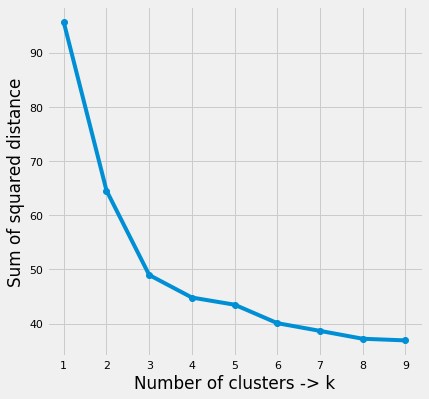

In [30]:
#list storing the sum of squared errors
ssd = []
#generating inertia values for range of k from 1 to 10
klist = list(range(1, 10))

for k in klist:
    km_elbow = KMeans_custom(n_clusters=k)
    km_elbow.fit(df_scaled)
    ssd.append(km_elbow.inertia_)

# Plot ssd against k
plt.figure(figsize=(6, 6))
plt.plot(klist, ssd, '-o')
plt.xlabel(r'Number of clusters -> k')
plt.ylabel('Sum of squared distance');

### Analysis based on Silhouette

No. of iterations to convergence: 7


<BarContainer object of 109 artists>

Text(-0.03, 54.5, '1')

<BarContainer object of 69 artists>

Text(-0.03, 143.5, '2')

[]

(-0.1, 1)

Text(0.5, 0, 'Silhouette coefficient values')

Text(0, 0.5, 'Cluster labels')

Text(0.5, 1.02, 'Silhouette plot for the various clusters')

No. of iterations to convergence: 7


<BarContainer object of 65 artists>

Text(-0.03, 32.5, '1')

<BarContainer object of 52 artists>

Text(-0.03, 91.0, '2')

<BarContainer object of 61 artists>

Text(-0.03, 147.5, '3')

[]

(-0.1, 1)

Text(0.5, 0, 'Silhouette coefficient values')

Text(0, 0.5, 'Cluster labels')

Text(0.5, 1.02, 'Silhouette plot for the various clusters')

No. of iterations to convergence: 9


<BarContainer object of 54 artists>

Text(-0.03, 27.0, '1')

<BarContainer object of 61 artists>

Text(-0.03, 84.5, '2')

<BarContainer object of 29 artists>

Text(-0.03, 129.5, '3')

<BarContainer object of 34 artists>

Text(-0.03, 161.0, '4')

[]

(-0.1, 1)

Text(0.5, 0, 'Silhouette coefficient values')

Text(0, 0.5, 'Cluster labels')

Text(0.5, 1.02, 'Silhouette plot for the various clusters')

No. of iterations to convergence: 8


<BarContainer object of 27 artists>

Text(-0.03, 13.5, '1')

<BarContainer object of 30 artists>

Text(-0.03, 42.0, '2')

<BarContainer object of 25 artists>

Text(-0.03, 69.5, '3')

<BarContainer object of 41 artists>

Text(-0.03, 102.5, '4')

<BarContainer object of 55 artists>

Text(-0.03, 150.5, '5')

[]

(-0.1, 1)

Text(0.5, 0, 'Silhouette coefficient values')

Text(0, 0.5, 'Cluster labels')

Text(0.5, 1.02, 'Silhouette plot for the various clusters')

No. of iterations to convergence: 7


<BarContainer object of 28 artists>

Text(-0.03, 14.0, '1')

<BarContainer object of 21 artists>

Text(-0.03, 38.5, '2')

<BarContainer object of 18 artists>

Text(-0.03, 58.0, '3')

<BarContainer object of 21 artists>

Text(-0.03, 77.5, '4')

<BarContainer object of 48 artists>

Text(-0.03, 112.0, '5')

<BarContainer object of 42 artists>

Text(-0.03, 157.0, '6')

[]

(-0.1, 1)

Text(0.5, 0, 'Silhouette coefficient values')

Text(0, 0.5, 'Cluster labels')

Text(0.5, 1.02, 'Silhouette plot for the various clusters')

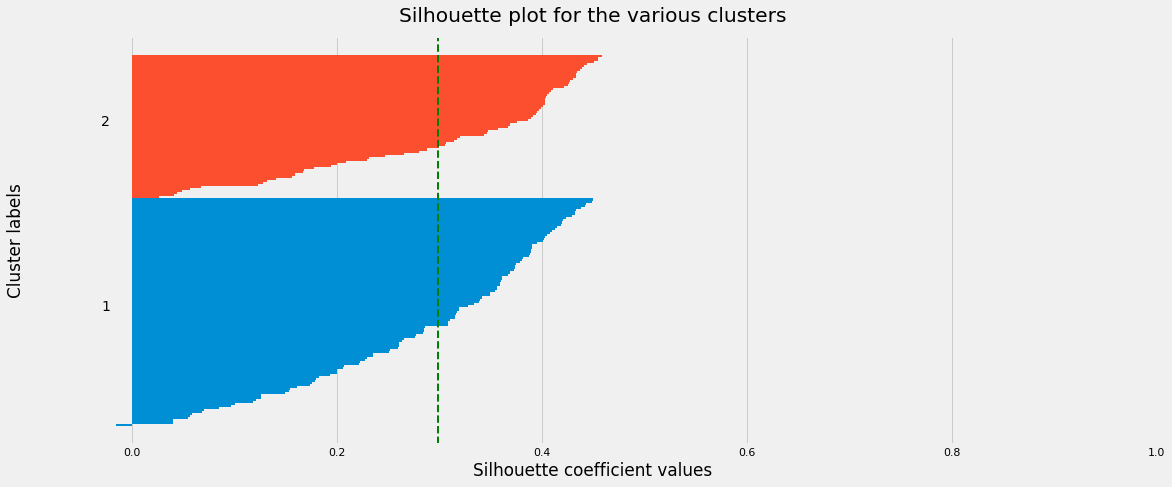

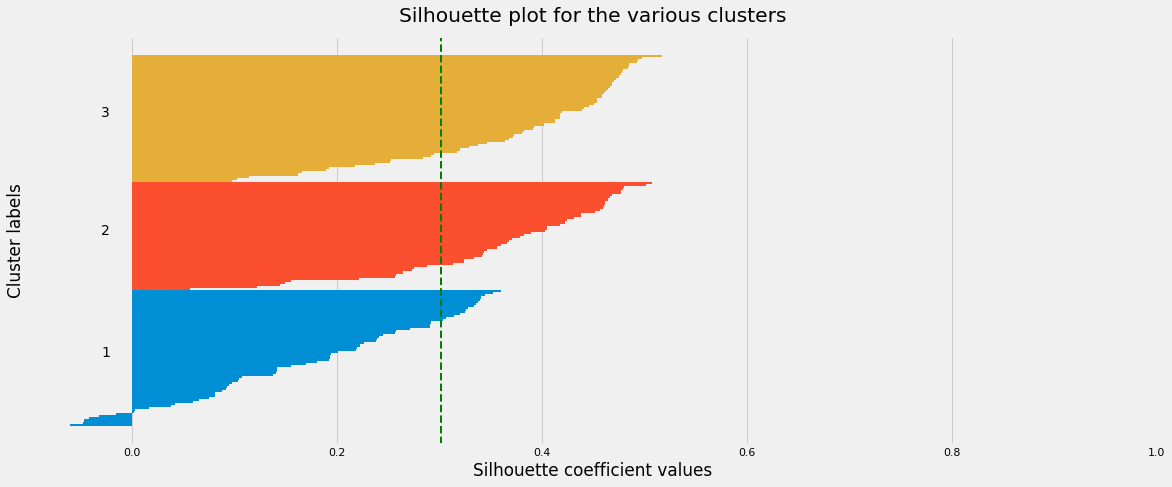

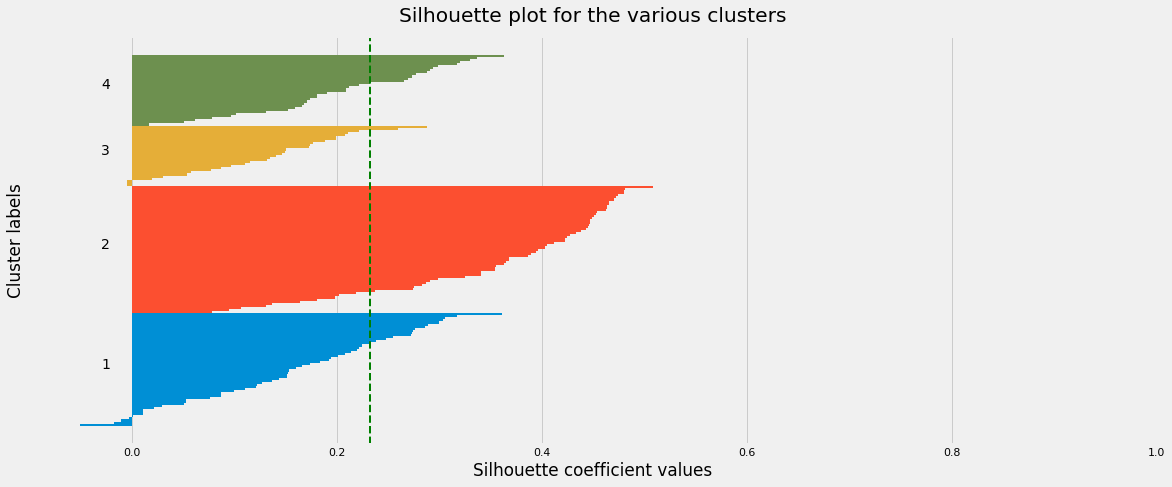

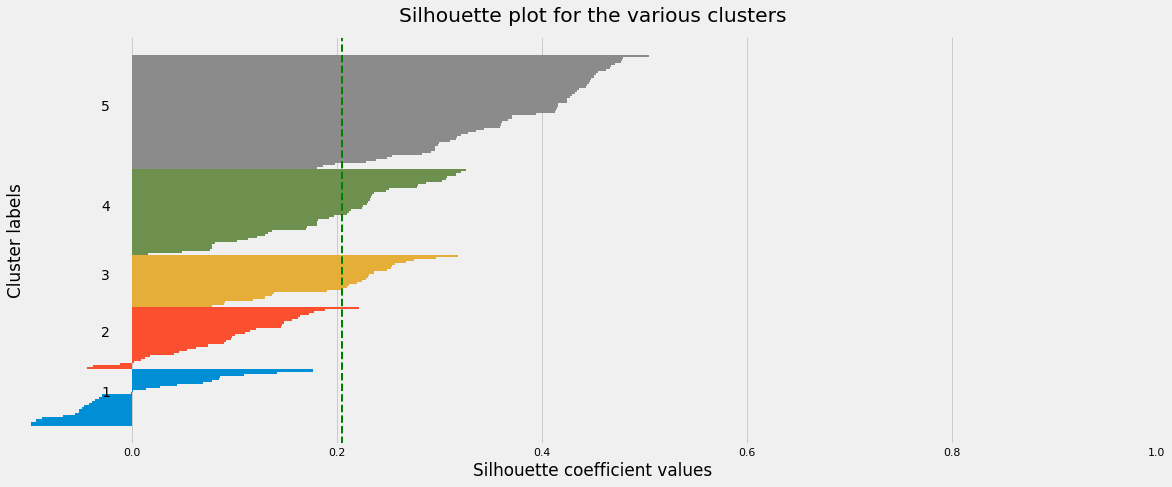

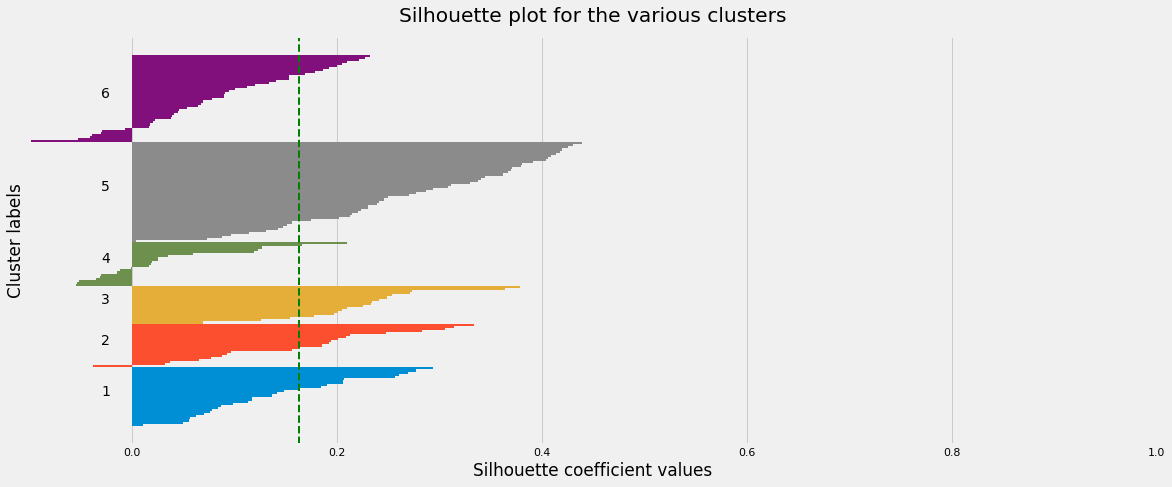

In [31]:
#Converting df to numpy array as its better for slicing
df_n = df_scaled.to_numpy()
for i, k in enumerate([2, 3, 4, 5 , 6]):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    
    # Run the KMeans_custom algorithm
    km = KMeans_custom(n_clusters=k)
    labels = km.fit_predict(df_n)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(df_n, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    

### References: